<a href="https://colab.research.google.com/github/CSID-DGU/2021-1-OSSP1-Debugger-4/blob/autoencoder/CNN_AUTOENCODER_ver1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1rsFeNH-ldl3-UCjRoEMUtuxPekRjTEgu?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:

# 라이브러리 설정
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import gc
import glob
from tensorflow.keras.layers import Reshape

# 랜덤 시드 고정
SEED=2021
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
#CelebA 압축해제
import zipfile
zipfile.ZipFile('./drive/MyDrive/img_align_celeba.zip').extractall('./celeba')

In [4]:
#CelebA train_data 불러오기
imgs = glob.glob('./celeba/img_align_celeba/*.jpg')

train_y = []
for _ in range(0,100000):
  if _%20000 == 0:
    print("{} / 100000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(64,64))
  train_y.append(img.astype("float32")/255.0)
  del img

Y = np.array(train_y)
del train_y
train_y=[]
gc.collect()


for _ in range(100000,200000):
  if _%20000 == 0:
    print("{} / 100000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(64,64))
  train_y.append(img.astype("float32")/255.0)
  del img

Y = np.vstack((Y,train_y))
del train_y
train_y=[]
gc.collect()
print(Y.shape)


0 / 100000
20000 / 100000
40000 / 100000
60000 / 100000
80000 / 100000
100000 / 100000
120000 / 100000
140000 / 100000
160000 / 100000
180000 / 100000


0

In [5]:
#CelebA test_data 불러오기
test_Y = []
for _ in range(200000,202599):
  if _%5000 == 0:
    print("{} / 100000".format(_))
  img = cv2.imread(imgs[_])
  img = cv2.resize(img,(64,64))
  test_Y.append(img.astype("float32")/255.0)
  
test_Y = np.array(test_Y)
print(test_Y.shape)

(200000, 64, 64, 3)
200000 / 100000
(2599, 64, 64, 3)


In [18]:
#민수 데이터 불러오기
minsu = glob.glob('./drive/MyDrive/videoimage3/*.png')
test_minsu = []
for _ in range(0,len(minsu)):
  img = cv2.imread(minsu[_])
  img = cv2.resize(img,(64,64))
  test_minsu.append(img.astype("float32")/255.0)
  
test_minsu = np.array(test_minsu)

print(test_minsu.shape)

(1912, 64, 64, 3)


In [34]:
real_test = glob.glob('./*.jpg')
real = []

img = cv2.imread(real_test[0])
img = cv2.resize(img,(64,64))
real.append(img.astype("float32")/255.0)

img = cv2.imread(real_test[1])
img = cv2.resize(img,(64,64))
real.append(img.astype("float32")/255.0)
  
real = np.array(real)

print(real.shape)

(1, 64, 64, 3)


In [19]:
# 오토인코더 모델 정의
def Autoencoder():

  X = tf.keras.layers.Input(shape=[64,64,3])

  #Encoder
  H = tf.keras.layers.Conv2D(32,(4,4),(2,2),activation='relu',padding='same')(X)
  H = tf.keras.layers.Conv2D(32*2,(4,4), (2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*4, (4,4),(2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*8, (4,4),(2,2),activation='relu',padding='same')(H)


  pool_tmp = H.shape.as_list()
  pool_tmp=pool_tmp[1:]
  

  #Fully-Connected
  H = tf.keras.layers.Flatten()(H)
  flatten_tmp=H.shape.as_list()
  flatten_tmp=flatten_tmp[1]
  H = tf.keras.layers.Dense(300,activation='relu')(H)
  H = tf.keras.layers.Dense(flatten_tmp,activation='relu')(H)
  H = Reshape(pool_tmp)(H)


  #Decoder
  H = tf.keras.layers.Conv2DTranspose(32*4,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32*2,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(3,(2,2),strides=(2,2),padding='same',activation='sigmoid')(H)

  model = tf.keras.models.Model(X,H)
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=['acc'])

  return model

ae_model = Autoencoder()
ae_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         524544    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               122910

In [59]:
for layers in (ae_model.layers):
    print(layers)

In [21]:
#모델 체크포인트 설정
checkpoint_path = 'checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only = True,
                                                save_best_only = True,
                                                moitor='val_accuracy',
                                                verbose=1)

In [22]:
# 오토인코더 모델 학습
history = ae_model.fit(Y,
                      Y,
                       batch_size=200,
                       epochs=20,
                       verbose=1,
                       shuffle=True,
                       callbacks=[checkpoint],
                       validation_split=0.2)
)
                      


Epoch 1/20
638/638 [==============================] - 20s 6ms/step - loss: 0.0252 - acc: 0.8324
Epoch 2/20
638/638 [==============================] - 4s 6ms/step - loss: 0.0055 - acc: 0.9109
Epoch 3/20
638/638 [==============================] - 4s 6ms/step - loss: 0.0035 - acc: 0.9239
Epoch 4/20
638/638 [==============================] - 3s 5ms/step - loss: 0.0028 - acc: 0.9318
Epoch 5/20
638/638 [==============================] - 3s 5ms/step - loss: 0.0024 - acc: 0.9360
Epoch 6/20
638/638 [==============================] - 4s 5ms/step - loss: 0.0022 - acc: 0.9386
Epoch 7/20
638/638 [==============================] - 3s 5ms/step - loss: 0.0020 - acc: 0.9411
Epoch 8/20
638/638 [==============================] - 3s 5ms/step - loss: 0.0020 - acc: 0.9428
Epoch 9/20
638/638 [==============================] - 4s 6ms/step - loss: 0.0018 - acc: 0.9441
Epoch 10/20
638/638 [==============================] - 4s 6ms/step - loss: 0.0017 - acc: 0.9441
Epoch 11/20
638/638 [===========================

In [62]:
ae_images = ae_model.predict(test_Y)
ae_images.shape

(2599, 64, 64, 3)

In [23]:
ae_images = ae_model.predict(test_minsu)
ae_images.shape

(1912, 64, 64, 3)

In [35]:
ae_images = ae_model.predict(real)
ae_images.shape

(1, 64, 64, 3)

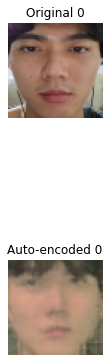

In [37]:

num = 10 
plt.figure(figsize=(20,8))
for i in range(10):
    # 원본 이미지
    ax = plt.subplot(2, num, i+1)
    plt.imshow(cv2.cvtColor(test_Y[i], cv2.COLOR_BGR2RGB).reshape((64,64,3)))
    plt.title("Original %s" % str(i))
    plt.axis('off')
    
    # 복원 이미지
    ax = plt.subplot(2, num, i+num+1)
    plt.imshow(cv2.cvtColor(ae_images[i], cv2.COLOR_BGR2RGB).reshape((64,64,3)))
    plt.title("Auto-encoded %s" % str(i))
    plt.axis('off')
    
plt.show()

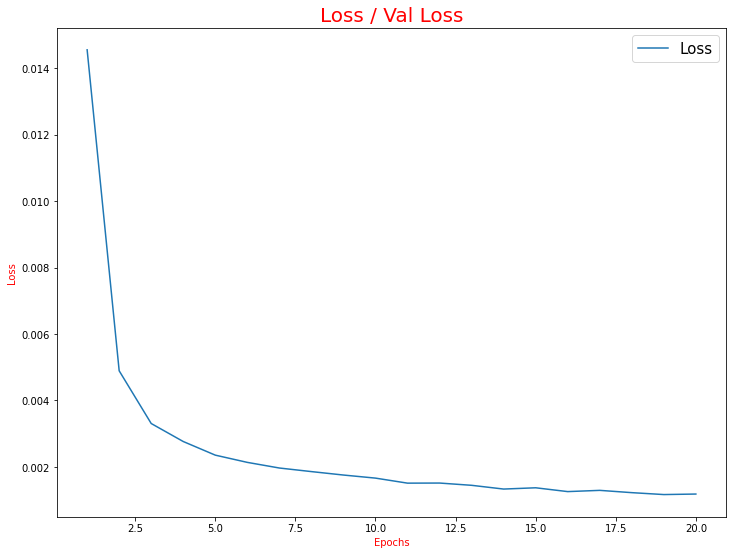

In [29]:
plt.figure(figsize=(12,9))
plt.plot(np.arange(1,21), history.history['loss'])
#plt.plot(np.arange(1,21), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20, color='red')
plt.xlabel('Epochs', color='red')
plt.ylabel('Loss',color='red')
plt.legend(['Loss', 'val_loss'], fontsize=15)
plt.show()